In [0]:
# conditional generative adversarial network using conv/deconv layers
# this version uses the ferg_db_256 database downsampled to 64x64

In [2]:
# mount drive to access csv files

from google.colab import drive
drive.mount('./data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./data


In [0]:
# conventional PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [4]:
# GPU

#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [0]:
import random
import pandas
import numpy
import cv2
import matplotlib.pyplot as plt

In [6]:
# function to generate uniform random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn((1,size))

generate_random(5)

tensor([[-0.8641, -0.5710, -1.1074,  0.1679,  0.9172]])

In [7]:
# function to generate one-hot random data used as a random target label
# size parameter is length of tensor

def generate_random_target(size):
    label_tensor = torch.zeros((1,size))
    random_idx = random.randint(0, size-1)
    label_tensor[0,random_idx] = 1.0
    
    return label_tensor

generate_random_target(5)

tensor([[1., 0., 0., 0., 0.]])

In [0]:
# emotions

list_of_emotions = ['happy', 'angry']

In [0]:
### generate images

def generate_real(emotion):
  # start with blank image
  img = numpy.zeros((128,128,3), numpy.uint8) + 255
  
  ####
  
  if (emotion == 'happy'):
  
    # happy colour
    r = 95
    g = 114
    b = 231

    for i in range(5):
      x = random.randint(20, 128-20)
      y = random.randint(20, 128-20)
      rad = random.randint(5, 10)

      rd = random.randint(-50,50)
      gd = random.randint(-50,50)
      bd = random.randint(-50,50)

      cv2.circle(img, (x,y), rad, (r+rd, g+gd, b+bd), -1, cv2.LINE_AA)
      pass
    
    pass
  
  ####
  
  if (emotion == 'angry'):
    
    # angry colour
    r = 169
    g = 20
    b = 54

    #for i in range(5):
    #  x = random.randint(20, 128-20)
    #  y = random.randint(20, 128-20)
    #  rad = random.randint(5, 10)

    #  rd = random.randint(-50,50)
    #  gd = random.randint(-50,50)
    #  bd = random.randint(-50,50)

    #  cv2.circle(img, (x,y), rad, (r+rd, g+gd, b+bd), -1, cv2.LINE_AA)
    #  pass
    
    # happy colour
    r = 95
    g = 114
    b = 231

    for i in range(5):
      x1 = random.randint(20, 128-20-30)
      y1 = random.randint(20, 128-20-30)
      x2 = x1 + 30
      y2 = y1 + 30
      rad = random.randint(5, 10)

      rd = random.randint(-50,50)
      gd = random.randint(-50,50)
      bd = random.randint(-50,50)

      cv2.line(img, (x1,y1), (x2, y2), (r+rd, g+gd, b+bd), 2, cv2.LINE_AA)
      pass
    
    pass
  
  ####
  
  # convert to fload
  img = img.astype(numpy.float)
  
  # add random noise
  img = img + numpy.random.normal(0, 1, (128, 128,3))*10
  img = numpy.clip(img, 0.0, 255.0)
  
  ####
  
  img_tensor = torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128)
  # rescale to (-1,1)
  img_tensor = (img_tensor / 127.5) - 1.0
  
  label_tensor = torch.zeros((1,len(list_of_emotions)))
  label_tensor[0,list_of_emotions.index(emotion)] = 1.0
    
  return label_tensor, img_tensor


### plot images

def plot_real(emotion):
  # plot a 3 column, 2 row array of sample images
  f, axarr = plt.subplots(2,3, figsize=(16,8))
  for i in range(2):
    for j in range(3):
      label_tensor, img_tensor = generate_real(emotion)
      img = img_tensor.permute(0,2,3,1).view(128,128,3).cpu().numpy()
      img = (img + 1.0)/2.0
      axarr[i,j].imshow(img)
      axarr[i,j].set_title(emotion)
      pass
    pass

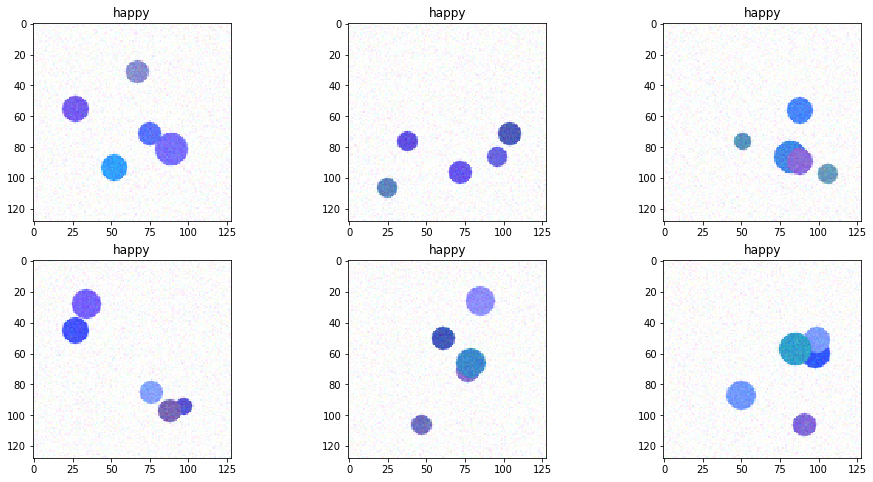

In [174]:
plot_real('happy')

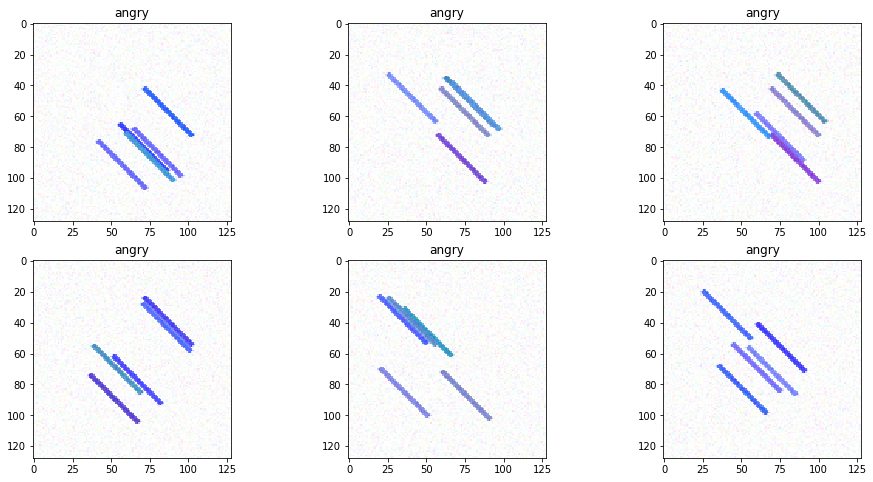

In [175]:
plot_real('angry')

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layer
        # input shape is (1, 3, height, width)
        
        # conv layers
        self.model1 = nn.Sequential(
            
            nn.Conv2d(3, 256, kernel_size=8, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=4, stride=1, bias=False),
            nn.LeakyReLU(0.2),
     
            View((1,3*9*9))
            
        )
        
        # dense layer
        self.model2 = nn.Sequential(
            
            nn.Linear(3*9*9 + len(list_of_emotions), 1),
            nn.Sigmoid()
            
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, image_tensor, label_tensor):
        # image first to conv layers
        inputs = image_tensor
        out1 = self.model1(inputs)
        
        # include labels to final dense layer
        inputs2 = torch.cat((out1, label_tensor),1)
        
        return self.model2(inputs2)
    
    
    def train(self, image_tensor, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(image_tensor, label_tensor)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 5000 == 0):
            print("counter = ", self.counter)
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 2.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0))
        pass
    
    pass

In [246]:
%%time
# create Discriminator and test it

D = Discriminator()
D.to(device)

# initialise weights
D.apply(weights_init)

# train Discriminator


for i in range(2000):

  # random emotion from list
  emotion = random.choice(list_of_emotions)

  # train discriminator on real data
  label_tensor, image_tensor = generate_real(emotion)
  D.train(image_tensor, label_tensor, torch.cuda.FloatTensor([1.0]).view(1,1))

  # train discriminator on false (random) data
  D.train(generate_random(3*128*128).view(1, 3, 128, 128), generate_random_target(2), torch.cuda.FloatTensor([0.0]).view(1,1))
  
  if(i%100 == 0):
    print("i = ", i)
    pass

  pass


i =  0
i =  100
i =  200
i =  300
i =  400
i =  500
i =  600
i =  700
i =  800
i =  900
i =  1000
i =  1100
i =  1200
i =  1300
i =  1400
i =  1500
i =  1600
i =  1700
i =  1800
i =  1900
CPU times: user 31.9 s, sys: 12.3 s, total: 44.2 s
Wall time: 44.5 s


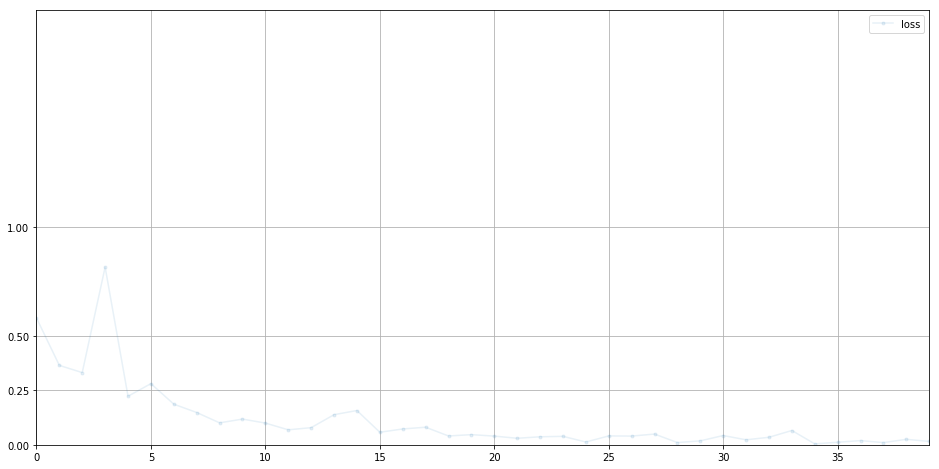

In [247]:
# plot discriminator error

D.plot_progress()

In [248]:
# manually check D can indeed discriminate between real and fake data

for i in range(4):
  print(D.forward(generate_random(3*128*128).view(1, 3, 128, 128),generate_random_target(len(list_of_emotions))).item())
  pass

print()

for i in range(4):
  idx = random.randint(0,len(list_of_emotions))
  label_tensor, image_data_tensor = generate_real('happy')
  print(D.forward(image_data_tensor, label_tensor).item())
  pass

print()

for i in range(4):
  idx = random.randint(0,len(list_of_emotions))
  label_tensor, image_data_tensor = generate_real('angry')
  print(D.forward(image_data_tensor, label_tensor).item())
  pass

0.01434062235057354
0.00515443179756403
0.011065218597650528
0.007119493559002876

0.9974949359893799
0.9977142810821533
0.9336726665496826
0.9984475374221802

0.999600350856781
0.999761164188385
0.9994462132453918
0.9998487234115601


In [0]:
# generator class
# this one uses only fully connected (nn.Linear) layers

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            
            # input is a 1d array
            nn.Linear(10 + len(list_of_emotions), 3*10*10),
            nn.LeakyReLU(0.2),
            
            # reshape to 2d
            View((1, 3, 10, 10)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2),
            
            
            View((1, 3, 128, 128)),
            nn.Tanh()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, noise_tensor, label_tensor):
        # combine image and label
        inputs = torch.cat((noise_tensor, label_tensor),1)
        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, noise_tensor, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(noise_tensor, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self, emotion):
        label_tensor = torch.zeros((1,len(list_of_emotions)))
        label_tensor[0,list_of_emotions.index(emotion)] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                img = G.forward(generate_random(10).view(1,10), label_tensor).permute(0,2,3,1).view(128,128,3).detach().cpu().numpy()
                img = (img + 1.0)/2.0
                axarr[i,j].imshow(img, interpolation='none')
                pass
            pass
        pass
      
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 10.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0))
        pass
    
    pass

torch.Size([1, 3, 128, 128])


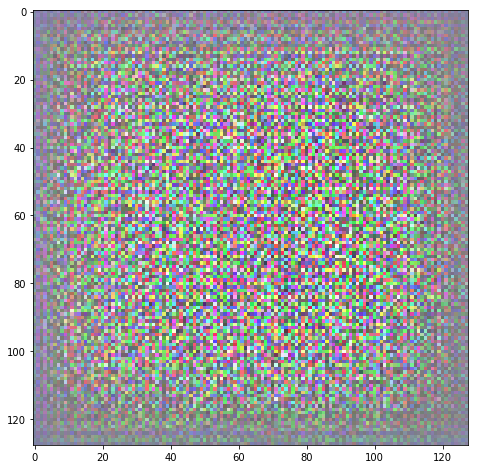

In [274]:
# scratch

G = Generator()
# initialise weights
G.apply(weights_init)

label_tensor = generate_random_target(len(list_of_emotions))

img = G(generate_random(10).view(1, 10), label_tensor)
img = (img + 1.0) / 2.0
print(img.shape)

plt.figure(figsize = (16,8))
plt.imshow(img.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy(), 
           interpolation='none')

In [0]:
# create Discriminator and Generator

D = Discriminator()
D.to(device)
# initialise weights
D.apply(weights_init)

G = Generator()
G.to(device)
# initialise weights
G.apply(weights_init)

# free up GPU memory 
torch.cuda.empty_cache()

In [305]:
%%time
# train Discriminator and Generator

    
for i in range(20000):

  # swap labels sometimes
  real = 0.9
  fake = 0.0
  #if (random.random() < 0.05):
  #  real = 0.0
  #  fake = 0.9
  #  pass
  
  
  # random emotion from list
  emotion = random.choices(list_of_emotions, weights=[1.0,1.1], k=1)[0]

  # train discriminator on real data
  label_tensor, image_tensor = generate_real(emotion)
  D.train(image_tensor, label_tensor, torch.cuda.FloatTensor([real]).view(1,1))

  # random 1-hot label for generator
  random_target_tensor = generate_random_target(len(list_of_emotions))

  # train discriminator on false
  # use detach() so only D is updated, not G
  # label softening doesn't apply to 0 labels
  D.train(G.forward(generate_random(10), random_target_tensor).detach(), random_target_tensor, torch.cuda.FloatTensor([fake]).view(1,1))

  # random 1-hot label for generator
  random_target_tensor = generate_random_target(len(list_of_emotions))

  # train generator
  G.train(D, generate_random(10), random_target_tensor, torch.cuda.FloatTensor([1.0]).view(1,1))
  
  pass


counter =  145000
counter =  150000
counter =  155000
counter =  160000
counter =  165000
counter =  170000
counter =  175000
counter =  180000
CPU times: user 10min 41s, sys: 5min 9s, total: 15min 50s
Wall time: 15min 57s


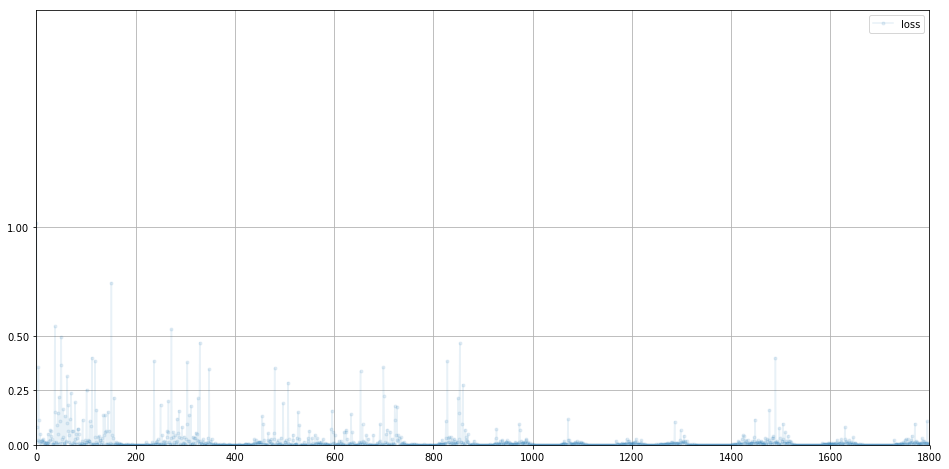

In [306]:
 # plot discriminator error

D.plot_progress()

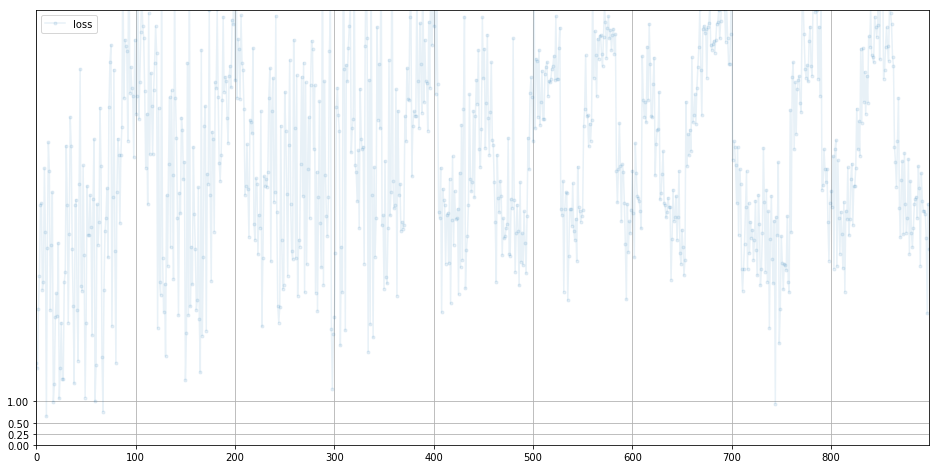

In [307]:
# plot generator error

G.plot_progress()

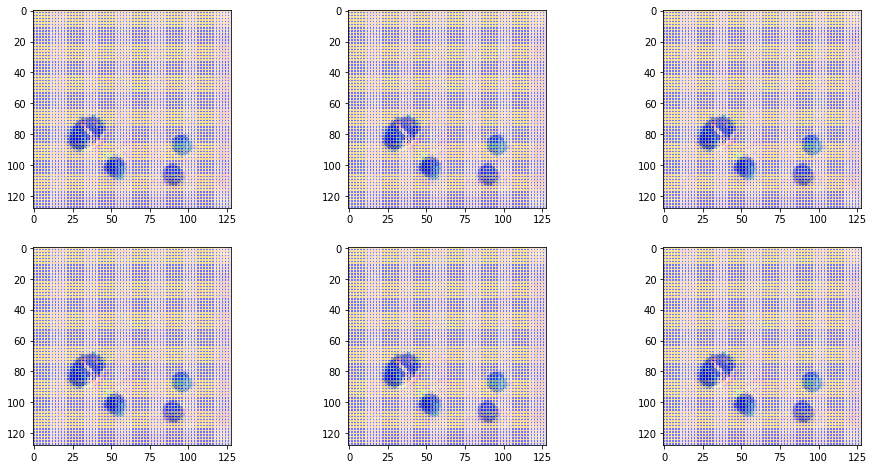

In [308]:
# show generator outputs as they evolve
# ['surprise', 'sadness', 'neutral', 'joy', 'fear', 'disgust', 'anger']

G.plot_images('happy')

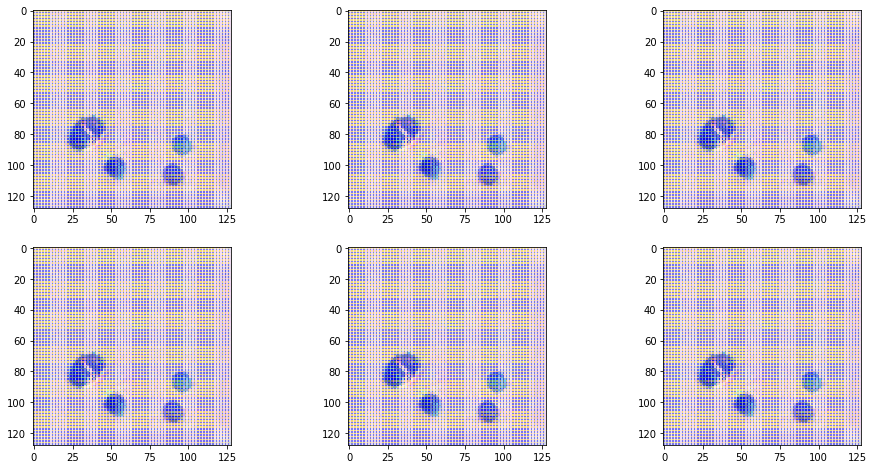

In [309]:
# show generator outputs as they evolve
# ['surprise', 'sadness', 'neutral', 'joy', 'fear', 'disgust', 'anger']

G.plot_images('angry')

tensor([[1., 1.]])


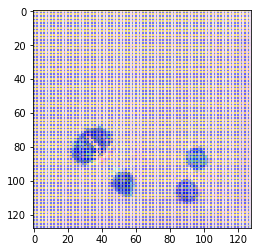

In [310]:
label_tensor = torch.zeros((1,len(list_of_emotions))) + 1
#label_tensor[0,list_of_emotions.index(emotion)] = 1.0
print(label_tensor)

img = G.forward(generate_random(10).view(1,10), label_tensor).permute(0,2,3,1).view(128,128,3).detach().cpu().numpy()
img = (img + 1.0)/2.0
plt.imshow(img, interpolation='none')